# Tutorial 1 -- Solutions

Author: Sarah Filippi. 

Date: 14/12/2023

Below are some libraries that will be usful for the tutorial. We also set the seed for reproducibility purposes.

In [26]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple
from scipy.stats import multivariate_normal

# set a random seed
seed = 1
np.random.seed(seed)


# Question 2 

a) The function below generates the data.

In [27]:
def generate_data() -> np.array:
    # Standard deviation of the noise to be added
    noise_std = 100

    # Set up the input variable, 100 points between -5 and 5
    x = np.linspace(-5, 5, 100)[:, None]

    # Calculate the true function and add some noise
    y = 5 * x ** 3 - x ** 2 + x + noise_std * np.random.normal(size=(x.shape[0], 1))

    # Concatenate x and y into a single matrix and return
    data = np.concatenate([x, y], axis=1)

    return data


(100, 2)

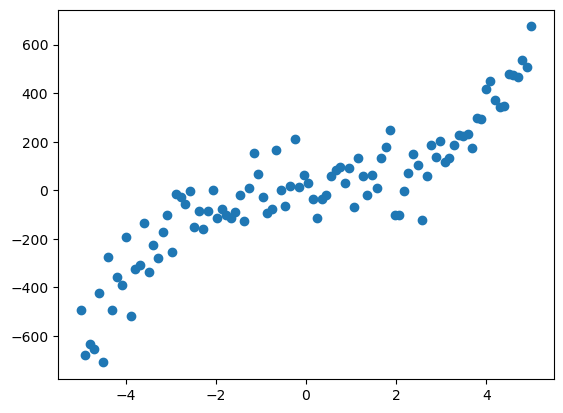

In [28]:
data = generate_data()
plt.scatter(data[:, 0], data[:, 1])

data.shape

b) MSE of a polynomial model

Below is a function that computes the MSE for a dataset given the order of a polynomial. 


In [29]:
def get_mse(x: np.ndarray, y: np.ndarray, poly_order: int) -> float:
    # x and y are vectors containing the inputs and targets respectively
    # PolyOrder is the order of polynomial model used for fitting
    # First construct design matrix of given order
    # pad the first column with ones i.e. intercept term
    X = np.ones((x.shape[0], 1))

    for p in range(1, poly_order + 1):
        X = np.concatenate([X, x ** p], axis=1)

    # solve for coefs such that X^T @ X @ coefs = X.T @ y
    coefs = np.linalg.solve(X.T @ X, X.T @ y)
    pred_y = X @ coefs
    mse = np.mean((pred_y - y) ** 2)

    return mse


We now compute the MSE for the generated data for different degrees of the polynome (from 1 to 8).

Text(0.5, 0, 'Order')

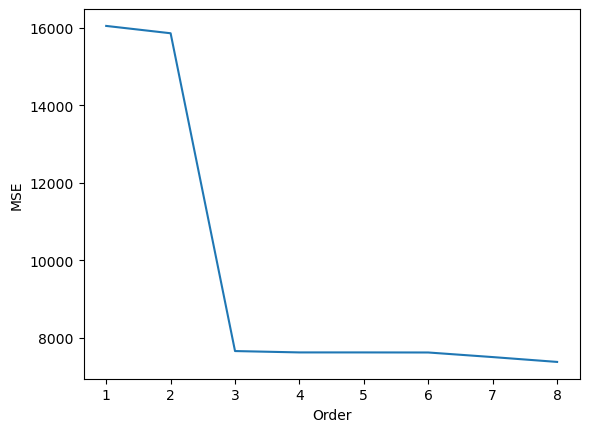

In [30]:
orders = [i for i in range(1, 9)]
plt.plot(orders, [get_mse(data[:, :1], data[:, 1:], p) for p in orders])
plt.ylabel("MSE")
plt.xlabel("Order")


We observe that the MSE on the dataset decreases as the degree of the polynome increases.

c) Train-test split

Split the dataset into training set (70%) and test set (30%) and plot the MSE for training set and test set separately

In [31]:
from sklearn.model_selection import train_test_split
seed=2

def get_mse_randomsplit(
    x: np.ndarray, y: np.ndarray, poly_order: int
) -> Tuple[float, float]:
    # x and y are vectors containing the inputs and targets respectively
    # poly_orde is the order of polynomial model used for fitting
    # First construct design matrix of given order
    # pad the first column with ones i.e. intercept term
    X = np.ones((x.shape[0], 1))

    for p in range(1, poly_order + 1):
        X = np.concatenate([X, x ** p], axis=1)

    # The function train_test_split splits the data into random train and test subsets. The test_size parameter specifies the ratio of the test set.
    # Note that the seed is fixed to ensure the same training/test split is used for all models
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=seed
    )

    # solve for coefs such that X^T @ X @ coefs = X.T @ y
    coefs = np.linalg.solve(X_train.T @ X_train, X_train.T @ y_train)
    pred_y = X_test @ coefs
    mse_test = np.mean((pred_y - y_test) ** 2)
    mse_train = np.mean((X_train @ coefs - y_train) ** 2)

    return mse_test, mse_train


[(21258.913573758266, 13979.379003774882), (21753.44068837372, 13963.501009279476), (8376.27967044063, 7554.912254159517), (8573.092056680141, 7494.999404483092), (8602.19292520372, 7494.044402463179), (11416.891115072496, 7011.301638713804), (11285.420114962206, 7006.442769098022), (13195.377857535215, 6908.047980450958)]


Text(0.5, 0, 'Order')

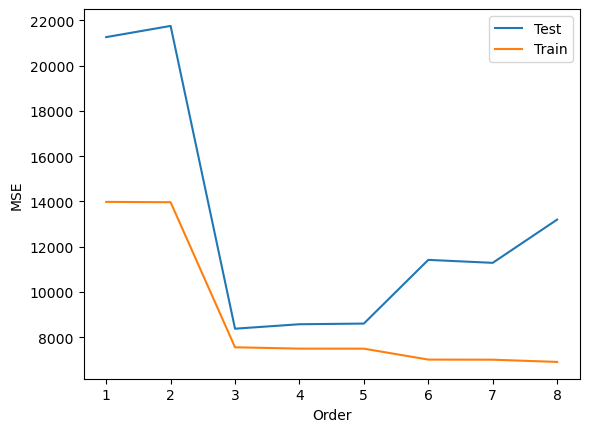

In [43]:
orders = [i for i in range(1, 9)]
MSE = [get_mse_randomsplit(data[:, :1], data[:, 1:], p) for p in orders]
plt.plot(
    orders,
    [sublist[0] for sublist in MSE],
    label="Test",
)
plt.plot(
    orders,
    [sublist[1] for sublist in MSE],
    label="Train",
)
plt.legend()
plt.ylabel("MSE")
plt.xlabel("Order")


d) Below is the code that performs Leave-on-out-cross validation (LOOCV). 

In [64]:

def get_LOOCV(x: np.ndarray, y: np.ndarray, poly_order: int) -> np.ndarray:
    # x and y are vectors containing the inputs and targets respectively
    # poly_order is the order of polynomial model used for fitting
    # First construct design matrix of given order
    # pad the first column with ones i.e. intercept term
    X = np.ones((x.shape[0], 1))

    for p in range(1, poly_order + 1):
        X = np.concatenate([X, x ** p], axis=1)

    CV = np.zeros((x.shape[0], 1))

    for i in range(x.shape[0]):
        X_train, X_test, y_train, y_test = (
            np.delete(X, i, axis=0),
            X[i,:],
            np.delete(y, i, axis=0),
            y[i,:],
        )
        # solve for coefs such that X^T @ X @ coefs = X.T @ y
        coefs = np.linalg.solve(X_train.T @ X_train, X_train.T @ y_train)
        pred_y = X_test @ coefs
        mse_test = np.mean((pred_y - y_test) ** 2)
        CV[i] = mse_test
    cv_mean = np.mean(CV)
    cv_sd = np.std(CV)

    return cv_mean, cv_sd


The fonction `KFold` from `sklearn.model_selection` can be used to create folds.

Below is a plot of the LOOCV error as a function of the polynomial order with the standard error represented with error bars.

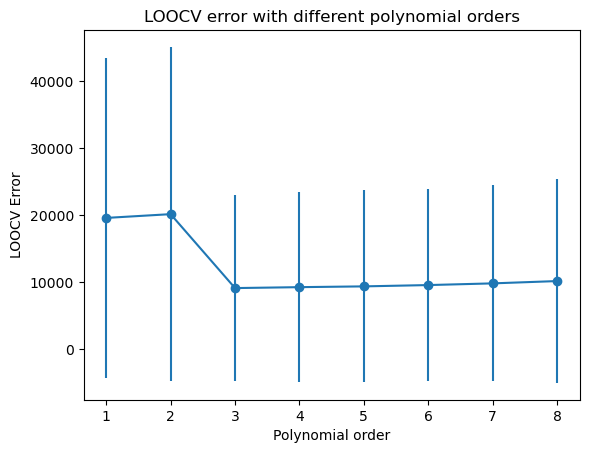

In [68]:
orders = [i for i in range(1, 9)]

# Initialize lists to store cv_mean and cv_sd
cv_means = []
cv_sds = []

# For each poly_order, run get_LOOCV and store cv_mean and cv_sd
for poly_order in orders:
    cv_mean, cv_sd = get_LOOCV(data[:, :1], data[:, 1:], poly_order)
    cv_means.append(cv_mean)
    cv_sds.append(cv_sd)

# Plot cv_mean as a line and cv_sd as error bars
plt.errorbar(orders, cv_means, yerr=cv_sds, fmt='-o')
plt.xlabel('Polynomial order')
plt.ylabel('LOOCV Error')
plt.title('LOOCV error with different polynomial orders')
plt.show()

e) Ridge regularised least squares

In [72]:

def get_ridge_LOOCV(
    x: np.ndarray, y: np.ndarray, lmbda: float, poly_order: int = 5
) -> np.ndarray:
    # x and y are vectors containing the inputs and targets respectively
    # PolyOrder is the order of polynomial model used for fitting
    # First construct design matrix of given order
    # pad the first column with ones i.e. intercept term
    X = np.ones((x.shape[0], 1))

    for p in range(1, poly_order + 1):
        X = np.concatenate([X, x ** p], axis=1)

    CV = np.zeros((x.shape[0], 1))

    for i in range(x.shape[0]):
        X_train, X_test, y_train, y_test = (
            np.delete(X, i, axis=0),
            X[i,:],
            np.delete(y, i, axis=0),
            y[i,:],
        )
        # solve for coefs such that X^T @ X @ coefs + lmbda diag(X.shape[1]) = X.T @ y
        coefs = np.linalg.solve(
            X_train.T @ X_train + lmbda * np.eye(X_train.shape[1]), X_train.T @ y_train
        )
        pred_y = X_test @ coefs
        mse_test = np.mean((pred_y - y_test) ** 2)
        CV[i] = mse_test
    cv_mean = np.mean(CV)
    cv_sd = np.std(CV)

    return cv_mean, cv_sd


Consider a polynomial of degree 5, below is a plot of the average LOOCV MSE (on the whole dataset) as a function of lambda.


Text(0.5, 0, '$\\lambda$')

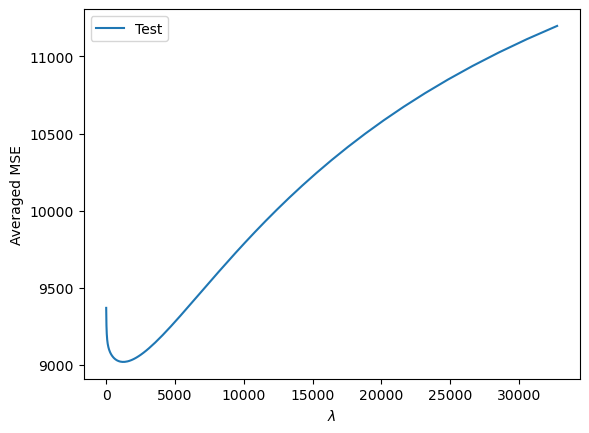

In [73]:
lmbdas = 2 ** np.linspace(0, 15, 151)
ridge_mses = [get_ridge_LOOCV(data[:, :1], data[:, 1:], lmbda)[0] for lmbda in lmbdas]
plt.plot(lmbdas, ridge_mses, label="Test")
plt.legend()
plt.ylabel("Averaged MSE")
plt.xlabel("$\lambda$")


In [75]:
# get the value of Lambda minimizing the LOOCV MSE
lmbda = lmbdas[np.argmin(ridge_mses)]
print("Lambda minimising LOOCV MSE=", lmbda)


Best lmbda 1260.691879265195


Let's now compare the MSE over the whole dataset of the OLS model and the ridge regression with the value of lambda chosen above. 

In [78]:
x = data[:, :1]
y = data[:, 1:]
X = np.ones((x.shape[0], 1))
for p in range(1, 5 + 1):
    X = np.concatenate([X, x ** p], axis=1)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=seed
)

# obtain ridge solution
coefs = np.linalg.solve(
    X_train.T @ X_train + lmbda * np.eye(X_train.shape[1]), X_train.T @ y_train
)
pred_y = X_test @ coefs
mse_ridge = np.mean((pred_y - y_test) ** 2)

# obtain OLS solution
coefs = np.linalg.solve(X_train.T @ X_train, X_train.T @ y_train)
pred_y = X_test @ coefs
mse_OLS = np.mean((pred_y - y_test) ** 2)

print(f"MSE_ridge: {mse_ridge}, MSE_OLS: {mse_OLS}")


MSE_ridge: 8891.641958208442, MSE_OLS: 9672.568707649818


# Question 3 

a) Generating the data

In [79]:
# dataset size
n = 100

# dataset and model properties
sigma_sq = 3
alpha = 0.5
beta = np.ones((2, 1))

# sample design matrix
X = np.concatenate([np.ones((n, 1)), np.random.normal(size=(n, 1))], axis=1)

# response
y = X @ beta + np.random.normal(scale=np.sqrt(sigma_sq), size=(n, 1))


Plot the data points


Text(0, 0.5, 'y')

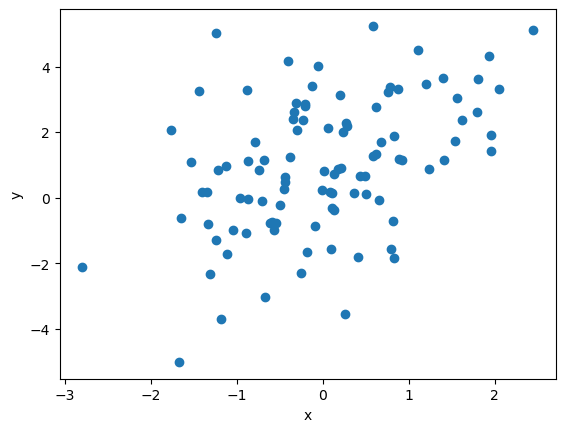

In [80]:
plt.scatter(X[:,1], y[:,0])
plt.xlabel("x")
plt.ylabel("y")

b) The following function computes the posterior mean and covariance for this linear model.

In [83]:
def solve_posterior(
    X: np.ndarray, y: np.ndarray, sigma_sq: np.ndarray, alpha: np.ndarray
) -> np.ndarray:
    n = X.shape[0]
    p = X.shape[1]
    mu = np.linalg.solve(X.T @ X + sigma_sq / alpha * np.eye(p), X.T @ y)
    Sigma = sigma_sq * np.linalg.solve(
        X.T @ X + (sigma_sq / alpha) * np.eye(p), np.eye(p)
    )
    return mu, Sigma


c) Posterior density using different number of data

First we define a function to plot the contours of a bivariate normal. 

In [61]:
import numpy as np
from scipy.stats import multivariate_normal

In [84]:
def plot_biv_normal(
    mu: np.ndarray, Sigma: np.ndarray, beta: np.ndarray, label: str = "num_points"
) -> None:
    x1 = np.linspace(-2, 2, 101)
    x2 = np.linspace(-2, 2, 101)
    xx, yy = np.meshgrid(x1, x2)

    eval_points = np.stack([xx.reshape(-1), yy.reshape(-1)], axis=1)
    d_mvn = multivariate_normal(mu[:, 0], Sigma)
    density = d_mvn.pdf(eval_points).reshape(xx.shape)
    plt.figure(figsize=(5, 3))
    contours = plt.contourf(xx, yy, density, levels=100, cmap="viridis")
    plt.colorbar()
    contours = plt.contour(
        xx, yy, density, levels=[0.5, 0.67, 0.95], colors="black", alpha=1
    )
    fmt = {}
    indicated_levels = [0.95, 0.67, 0.5]
    for l, s in zip(contours.levels, indicated_levels):
        fmt[l] = s
    plt.clabel(contours, contours.levels, fontsize=8, fmt=fmt)

    # add the points to show where the MAP estimate and true parameters are
    # red star = True parameters
    # black dot = MAP estimate
    plt.scatter(
        beta[0], beta[1], color="red", label="True Parameter", marker=(5, 2), s=40
    )
    plt.scatter(mu[0], mu[1], color="black", label="MAP Estimate", s=40)
    # adjust these if you can't see the contours
    plt.xlim((-1, 2))
    plt.ylim((0, 2))
    plt.xlabel(r" $\beta_1$")
    plt.ylabel(r" $\beta_2$")
    plt.title(label)
    plt.legend()


Now we calculate the posterior using the first $n \in \{10,30,100\}$ points in the dataset. This is a bivariate normal for our model as it has a Gaussian likelihood and prior and two parameters.


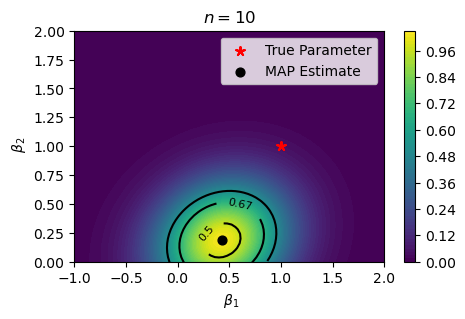

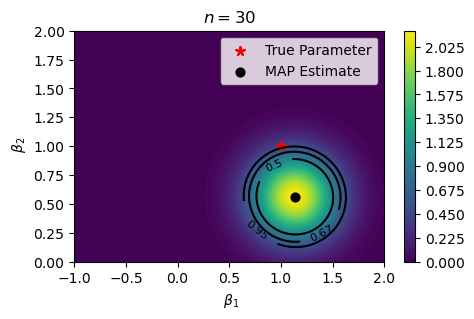

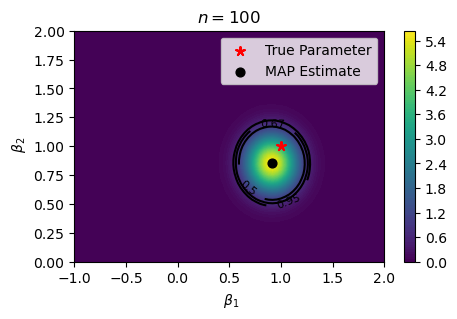

In [85]:
n_list = [10, 30, 100]
for n in n_list:
    mu, Sigma = solve_posterior(X[:n], y[:n], sigma_sq, alpha)
    plot_biv_normal(mu, Sigma, beta, label=f"$n={n}$")


The countours are plotted where the density is 0.5, 0.67 and 0.95. For the left plot (10 data points) the contour corresponding to a density of 0.5 and 0.67 is outside of the axis as the model is highly uncertain.

We notice that
1. the MAP estimate is closer to the true values as the number of data increase
2. the posterior is more concentrated as the number of data increase

# Question 4

We start by importing the data from the csv file using `genfromtxt` from numpy.

In [1]:
import numpy as np

# Replace 'filename.csv' with the path to your CSV file
data = np.genfromtxt('dataQ4.csv', delimiter=',', skip_header=1)
data.shape

x = data[:, 0]
z = data[:,1]
y = data[:,2]



## Part 1 of question 4

We consider the following model
$$Y_i= aZ_i + (b_1+b_2 Z_i)\cos(X_i) +(c_1+c_2Z_i)X_i+ (d_1+d_2Z_i)X_i^2+ (e_1+e_2Z_i)X_i^3  +\epsilon_i$$

where $\epsilon_i$ are independent random variables such that $E(\epsilon_i)=0$.

We construct the set of 9 features from the dataset and then infer a ridge regression model. We use LOOCV to learn the regularization parameter $\lambda$ by minimizing the MSE error. We consider the following grid of values for $\lambda=2^k$ for $k\in\{-10,-9.9, -9.8,\dots -1.9,-2\}$. We obtain the following plot of the average MSE on the LOOCV as a function of $\lambda$. 


In [2]:
# Create the design matrix
Xall = np.stack([z, np.cos(x), z*np.cos(x), x, z*x, x**2, z * x**2, x**3, z * x**3], axis=1)

Xall.shape

(100, 9)

The following function performs LOOCV to choose the regularisation parameter lambda:

In [3]:
def LOOCV_lambda(X, y, lambda_):
    # X is the matrix of features (including polynomials)
    # y is a vector containing the targets
    # lambda_ is the parameter for ridge regression

    NumOfDataPairs = len(y)

    # Initialize CV variable for storing results
    CV = np.zeros(NumOfDataPairs)

    for n in range(NumOfDataPairs):

        # Create training design matrix and target data, leaving one out each time
        Train_X = np.delete(X, n, axis=0)
        Train_y = np.delete(y, n)

        # Create testing design matrix and target data
        Test_X = X[n, :]
        Test_y = y[n]

        # Learn the optimal parameters using MSE loss
        Paras_hat = np.linalg.solve(Train_X.T @ Train_X + lambda_ * np.eye(X.shape[1]), Train_X.T @ Train_y)
        Pred_y = Test_X @ Paras_hat

        # Calculate the MSE of prediction using training data
        CV[n] = (Pred_y - Test_y) ** 2

    return np.mean(CV)


def get_MSE_ridge(X,y,lamb):

    #now do LOO-CV
    CV = np.zeros([X.shape[0],1])
    for i in range(X.shape[0]):
        X_train, X_test = np.delete(X,i,axis = 0), X[i,:]
        y_train, y_test = np.delete(y, i, axis=0), y[i, :]
    #solve
        coeffs = np.linalg.solve((X_train.T @ X_train) + lamb * np.eye(X_train.shape[1]), X_train.T @ y_train)
        y_pred_test = X_test @ coeffs
        mse_test = np.mean((y_pred_test - y_test) ** 2)
        CV[i] = mse_test
    CV_mean = np.mean(CV)
    CV_sd = np.std(CV)

    return CV_mean,CV_sd

We apply this function to a grif of values of lamdbda. 

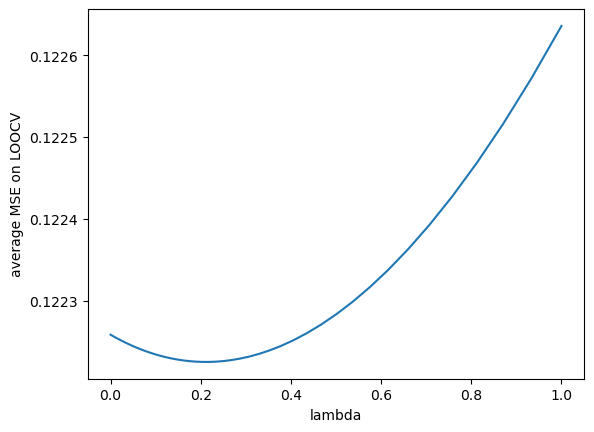

Average MSE on LOOCV minimized for lambda_hat = 0.2176


In [14]:
# Create a list of lambda values
lambdalist = np.concatenate(([0], 2 ** np.arange(-10, 0.1, 0.1)))

# Apply the LOOCV_lambda function to each lambda value
CVlambda = np.array([LOOCV_lambda(Xall, y, lambda_) for lambda_ in lambdalist])
CVlambda2 = 

# Plot the average MSE on LOOCV against lambda
plt.plot(lambdalist, CVlambda)
plt.xlabel('lambda')
plt.ylabel('average MSE on LOOCV')
plt.show()

# Find the lambda value that minimizes the average MSE
lambda_l = lambdalist[np.argmin(CVlambda)]

print(f"Average MSE on LOOCV minimized for lambda_hat = {lambda_l:.4f}")
#We obtain the following values:



We then fix regularisation parameter to the value that minimse the avergae MSE on LOOCV  and learn the model parameters on the entire dataset. 

In [18]:
Paras_hat = np.linalg.solve(Xall.T @ Xall + lambda_l * np.eye(9), Xall.T @ y)

# Define the names
names = ["a", "b1", "b2", "c1", "c2", "d1", "d2", "e1", "e2"]
# Print the names and values
for name, value in zip(names, Paras_hat):
    print(f"{name}: {value}")

a: 0.055040582023473124
b1: 1.064547565431265
b2: 0.8684622021056096
c1: -0.012238303056648914
c2: -0.004749225913787544
d1: 0.0014044678476760062
d2: 0.0952308910888189
e1: 0.031834144512766435
e2: 5.6290995469426e-05


We can now perform prediction and produce a plot of the data (dots) together with the model prediction (red line) for z=0 and z=1 respectively.


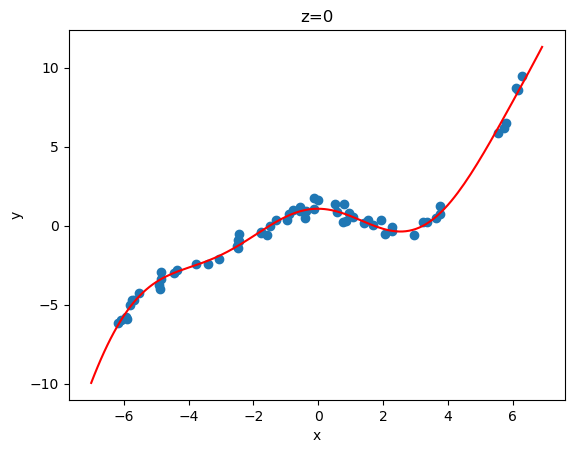

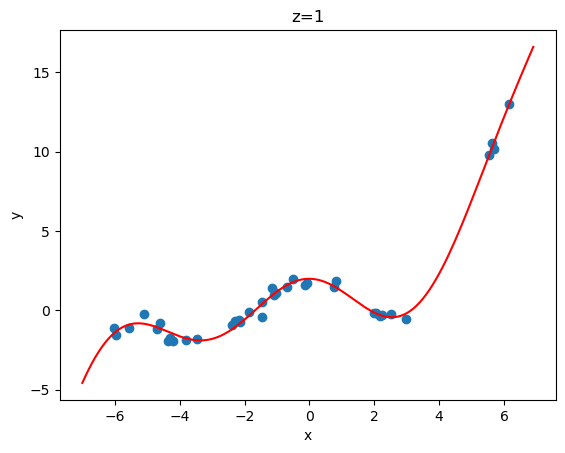

In [38]:
# Create a sequence of test x values
xtest = np.arange(-7, 7, 0.1)

# Create the design matrices for testing
Xalltest1 = np.column_stack([np.ones_like(xtest), np.cos(xtest), np.cos(xtest), xtest, xtest, xtest**2, xtest**2, xtest**3, xtest**3])
Xalltest0 = np.column_stack([np.zeros_like(xtest), np.cos(xtest), np.zeros_like(xtest), xtest, np.zeros_like(xtest), xtest**2, np.zeros_like(xtest), xtest**3, np.zeros_like(xtest)])

# Calculate the predictions
Pred_Test0 = Xalltest0 @ Paras_hat
Pred_Test1 = Xalltest1 @ Paras_hat

# Plot the predictions for z=0
plt.figure()
plt.plot(xtest, Pred_Test0, color="red")
plt.scatter(x[z==0], y[z==0])
plt.xlabel("x")
plt.ylabel("y")
plt.title("z=0")

# Plot the predictions for z=1
plt.figure()
plt.plot(xtest, Pred_Test1, color="red")
plt.scatter(x[z==1], y[z==1])
plt.xlabel("x")
plt.ylabel("y")
plt.title("z=1")

plt.show()

## Part 2 of question 4

Suppose now that $\epsilon_i\sim \mathcal{N}(0,0.1)$. Suppose that the parameters are *a priori* independent and consider a Gaussian prior distribution with mean $0$ and variance $\alpha$ for each parameter. 

The posterior distribution of the model parameters is a multivariate Normal distribution with mean  and variance respectively equal to 
$$
\boldsymbol{\mu}=\left(\Phi^{T} \Phi+\frac{\sigma^{2}}{\alpha} \mathbf{I}\right)^{-1} \Phi^{T} \mathbf{y} \quad\text{ and }\quad \mathbf{\Sigma}=\sigma^{2}\left(\Phi^{T} \Phi+\frac{\sigma^{2}}{\alpha} \mathbf{I}\right)^{-1}
$$
where $\Phi$ denotes the design matrix and $\sigma^2=0.1$.

Below is a plot of the posterior mean as a function of $\alpha$.

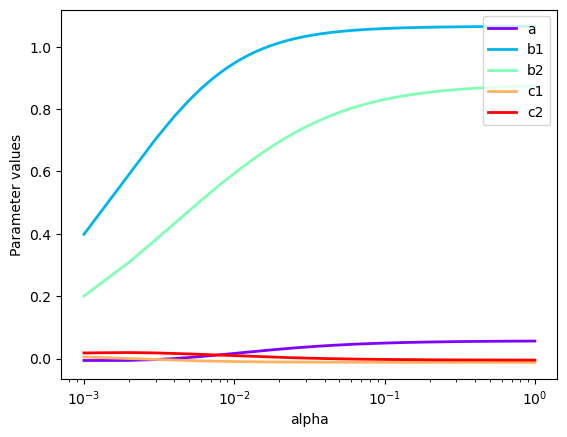

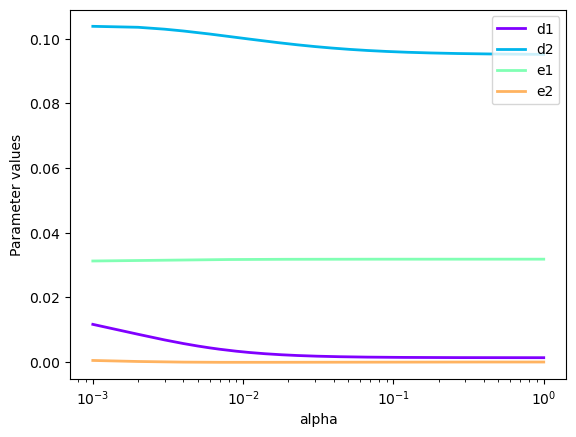

In [44]:
# Define sigma and alpha list
sigma = np.sqrt(0.1)
alphalist = np.arange(0.001, 1.001, 0.001)

# Calculate t for each alpha
t = np.array([np.linalg.solve(Xall.T @ Xall + np.diag(np.repeat(sigma**2/alpha, Xall.shape[1])), Xall.T @ y) for alpha in alphalist])

# Define color palette
color_palette = plt.cm.rainbow(np.linspace(0, 1, 5))

# Plot the first 5 rows of t against alpha
plt.figure()
for i in range(5):
    plt.plot(alphalist, t[:, i], color=color_palette[i], linewidth=2)
plt.xlabel("alpha")
plt.ylabel("Parameter values")
plt.xscale("log")
plt.legend(["a", "b1", "b2", "c1", "c2"], loc="upper right")

# Plot the last 4 rows of t against alpha
plt.figure()
for i in range(5, 9):
    plt.plot(alphalist, t[:, i], color=color_palette[i-5], linewidth=2)
plt.xlabel("alpha")
plt.ylabel("Parameter values")
plt.xscale("log")
plt.legend(["d1", "d2", "e1", "e2"], loc="upper right")

plt.show()

Possible points for discussion (at least two of these points expected): 

* State which parameters are increasing/decreasing with $\alpha$; State which parameters are constant with $\alpha$ (especially of interest the ones with values close to 0 -- here c1, c2, e2)
* One might remark that when $\alpha$ increases, the prior becomes "flat". The estimated parameters therefore correspond to the ones that minimize the MSE.
* Note that when $\alpha=\sigma^2/\hat\lambda$ where $\hat\lambda$ is defined in the previous question, the posterior mean is equal to the parameters obtained in the previous question using ridge regression with a regularisation parameter equal to $\hat\lambda$.
* Could also comment on parameters for very small value of $\alpha$ (tight prior around 0).


The posterior predictive distribution for a new observation $(x^*,z^*)$ is a normal distribution with mean $\Phi^{*T} \boldsymbol{\mu}$ and variance $\Phi^{*T} \mathbf{\Sigma} \Phi^*+\sigma^2$ where $\Phi^*$ denotes the vector of features for the new observation. We can compute the mean and variance of the posterior predictive for any observation. A 95% credible interval is given by $[\Phi^{*T} \boldsymbol{\mu} -\gamma \sqrt{\Phi^{*T} \mathbf{\Sigma} \Phi^*+\sigma^2 }, Phi^{*T} \boldsymbol{\mu} +\gamma \sqrt{\Phi^{*T} \mathbf{\Sigma} \Phi^*+\sigma^2 }]$ where $\gamma$ is the 2.5 percentile of a standard normal distribution. We now plot the mean of the posterior prediction (red line) along with the 95% credible interval (grey line) as a function of x for the two values of z. 

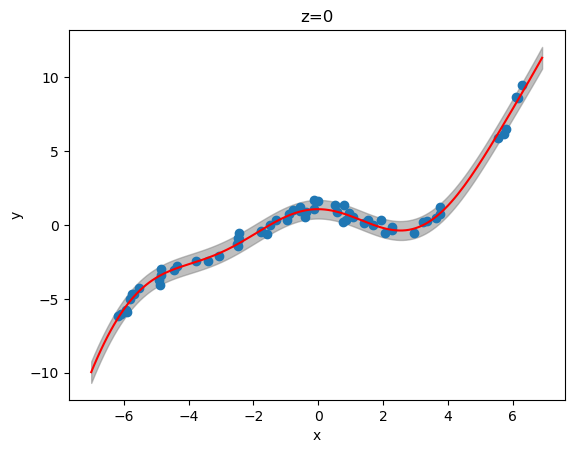

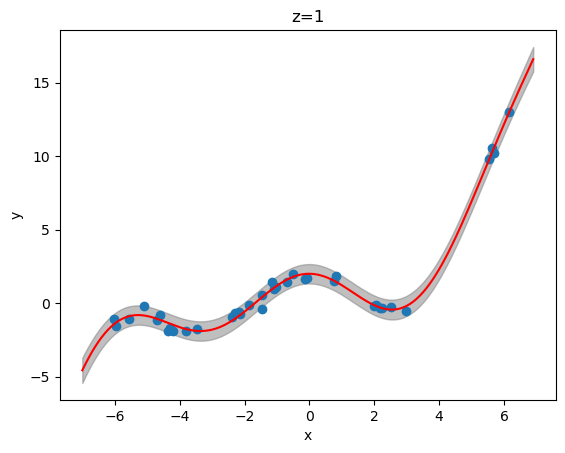

In [50]:
from scipy.stats import norm

# Define alpha and sigma
alpha = 1
sigma = np.sqrt(0.1)

# Calculate muhat and Sigma
muhat = np.linalg.solve(Xall.T @ Xall + np.diag(np.repeat(sigma**2/alpha, Xall.shape[1])), Xall.T @ y)
Sigma = sigma**2 * np.linalg.solve(Xall.T @ Xall + np.diag(np.repeat(sigma**2/alpha, Xall.shape[1])), np.eye(Xall.shape[1]))

# Calculate posterior predictive mean and variance for z=0
meanpred0 = Xalltest0 @ muhat
Varpred0 = np.diag(Xalltest0 @ Sigma @ Xalltest0.T + np.diag(np.repeat(sigma**2, Xalltest0.shape[0])))

# Calculate up0 and low0
gamma = norm.ppf(0.975)
up0 = meanpred0 + gamma * np.sqrt(Varpred0)
low0 = meanpred0 - gamma * np.sqrt(Varpred0)

# Plot meanpred0 with confidence intervals
plt.figure()
plt.plot(xtest, meanpred0, color="red")
plt.fill_between(xtest, low0, up0, color="grey", alpha=0.5)
plt.scatter(x[z==0], y[z==0])
plt.xlabel("x")
plt.ylabel("y")
plt.title("z=0")

# Calculate posterior predictive mean and variance for z=1
meanpred1 = Xalltest1 @ muhat
Varpred1 = np.diag(Xalltest1 @ Sigma @ Xalltest1.T + np.diag(np.repeat(sigma**2, Xalltest1.shape[0])))

# Calculate up1 and low1
up1 = meanpred1 + gamma * np.sqrt(Varpred1)
low1 = meanpred1 - gamma * np.sqrt(Varpred1)

# Plot meanpred1 with confidence intervals
plt.figure()
plt.plot(xtest, meanpred1, color="red")
plt.fill_between(xtest, low1, up1, color="grey", alpha=0.5)
plt.scatter(x[z==1], y[z==1])
plt.xlabel("x")
plt.ylabel("y")
plt.title("z=1")

plt.show()

Possible comments:

* Good fit
* Most of the data are within the 95% credible interval of the posterior predictive.




